# **Alzheimer's MRI Image Classification CNN**

# Dataset Description:
The dataset comprises MRI images sourced from various websites, ensuring the authenticity of each label. It contains four classes of images in both the training and testing sets:

1. Mild Demented
2. Moderate Demented
3. Non-demented
4. Very Mild Demented

Directory Structure:
The dataset consists of two files: Training and Testing, each containing approximately 5000 images categorized by the severity of Alzheimer's.

Class Labels:
1. MildDemented
2. VeryMildDemented
3. NonDemented
4. ModerateDemented


In [1]:
#import paskages
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.utils import resample


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from keras.layers import *
from sklearn.metrics import classification_report, accuracy_score


2024-04-08 18:40:21.315322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 18:40:21.315424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 18:40:21.467035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


###### Load images


In [2]:
# Set directories
train_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
test_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'


In [3]:

# Get class names
class_names = os.listdir(train_dir)
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

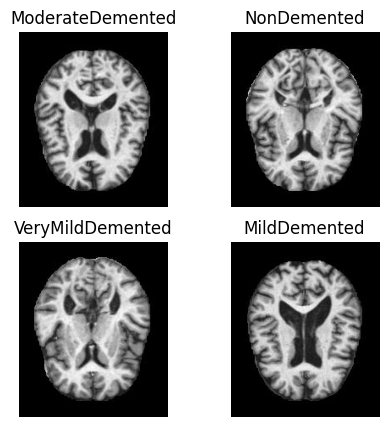

In [4]:
# Print sample images from each class
plt.figure(figsize=(5, 5))
for i, class_name in enumerate(class_names):
    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_dir, class_name)))
    img_path = os.path.join(train_dir, class_name, img_name)
    
    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()


In [5]:
# Function to preprocess images
def preprocess_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [6]:
# Load image paths and labels
X = []
y = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        X.append(os.path.join(class_dir, img_name))
        y.append(class_name)

In [7]:
# Split data into training and testing sets while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
# Count number of samples in each class for training and testing sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)


In [9]:
# Print the count of each class for training set before upsampling
print("Training Set Class Counts (Before Upsampling):")
for class_name, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"{class_name}: {count} samples")


Training Set Class Counts (Before Upsampling):
MildDemented: 573 samples
ModerateDemented: 42 samples
NonDemented: 2048 samples
VeryMildDemented: 1433 samples


In [10]:
# Print the count of each class for testing set
print("\nTesting Set Class Counts:")
for class_name, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"{class_name}: {count} samples")



Testing Set Class Counts:
MildDemented: 144 samples
ModerateDemented: 10 samples
NonDemented: 512 samples
VeryMildDemented: 359 samples


###### There are implanace on data

 will use Upsample minority

In [11]:
# Function to upsample minority classes
def upsample_minority_classes(X_train, y_train):
    df_train = pd.DataFrame({'image_path': X_train, 'class': y_train})
    class_counts = df_train['class'].value_counts()
    max_class_count = class_counts.max()

    dfs_upsampled = []
    for class_name, count in class_counts.items():
        df_class = df_train[df_train['class'] == class_name]
        if count < max_class_count:
            df_upsampled = resample(df_class, replace=True, n_samples=max_class_count, random_state=42)
            dfs_upsampled.append(df_upsampled)
        else:
            dfs_upsampled.append(df_class)

    df_train_upsampled = pd.concat(dfs_upsampled)
    X_train_upsampled = df_train_upsampled['image_path'].values
    y_train_upsampled = df_train_upsampled['class'].values
    return X_train_upsampled, y_train_upsampled

In [12]:
# Function to upsample minority classes in test data
def upsample_test_minority_classes(X_test, y_test):
    # Combine features and labels into a DataFrame
    df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

    # Separate majority and minority classes
    df_majority_test = df_test[df_test['label'].isin(['NonDemented'])]
    df_minority1_test = df_test[df_test['label'].isin(['MildDemented'])]
    df_minority2_test = df_test[df_test['label'].isin(['ModerateDemented'])]
    df_minority3_test = df_test[df_test['label'].isin(['VeryMildDemented'])]

    # Upsample minority classes
    df_minority_upsampled1_test = resample(df_minority1_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled2_test = resample(df_minority2_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled3_test = resample(df_minority3_test, replace=True, n_samples=len(df_majority_test), random_state=42)

    # Combine majority class with upsampled minority classes
    df_upsampled_test = pd.concat([df_majority_test, df_minority_upsampled1_test, df_minority_upsampled2_test, df_minority_upsampled3_test])

    # Shuffle the dataframe
    df_upsampled_test = df_upsampled_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    X_test_upsampled = df_upsampled_test['image_path'].values
    y_test_upsampled = df_upsampled_test['label'].values

    return X_test_upsampled, y_test_upsampled

In [13]:
# Upsample minority classes in the training set
X_train_upsampled, y_train_upsampled = upsample_minority_classes(X_train, y_train)


In [14]:
# Upsample minority classes in the test set
X_test_upsampled, y_test_upsampled = upsample_test_minority_classes(X_test, y_test)


###### Data augmentation 

In [15]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)

In [16]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train_upsampled, 'class': y_train_upsampled}),
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 8192 validated image filenames belonging to 4 classes.


In [18]:
# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test_upsampled, 'label': y_test_upsampled}),
    directory=None,  
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 2048 validated image filenames belonging to 4 classes.


In [19]:
# After applying ImageDataGenerator, you can check the count of each label
train_label_counts = train_generator.classes
test_label_counts = test_generator.classes

# Count occurrences of each class label
train_label_counts = np.bincount(train_label_counts)
test_label_counts = np.bincount(test_label_counts)




In [20]:
# Print the count of each class for the training set
print("Training Set Class Counts (After Augmentation):")
for i, count in enumerate(train_label_counts):
    print(f"Class {i}: {count} samples")



Training Set Class Counts (After Augmentation):
Class 0: 2048 samples
Class 1: 2048 samples
Class 2: 2048 samples
Class 3: 2048 samples


In [21]:
# Print the count of each class for the testing set
print("\nTesting Set Class Counts:")
for i, count in enumerate(test_label_counts):
    print(f"Class {i}: {count} samples")


Testing Set Class Counts:
Class 0: 512 samples
Class 1: 512 samples
Class 2: 512 samples
Class 3: 512 samples


In [22]:
# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])





/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [23]:
# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
   metrics=['accuracy'])


In [24]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_weights.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [25]:
# Train model
history = model.fit(train_generator , validation_data=test_generator , epochs=50 ,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-08 18:40:50.475646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.51517, expected 6.61089
2024-04-08 18:40:50.475711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.9143, expected 7.01001
2024-04-08 18:40:50.475732: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.72555, expected 4.82127
2024-04-08 18:40:50.475741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 7.36992, expected 6.46564
2024-04-08 18:40:50.475749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1

  2/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.2148 - loss: 2.0049  

I0000 00:00:1712601660.882618      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712601660.904325      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.2597 - loss: 1.4848

W0000 00:00:1712601759.100184      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.38354, saving model to best_weights.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 129s 842ms/step - accuracy: 0.2597 - loss: 1.4842 - val_accuracy: 0.2500 - val_loss: 1.3835
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.3048 - loss: 1.3627
Epoch 2: val_loss improved from 1.38354 to 1.19773, saving model to best_weights.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 94s 696ms/step - accuracy: 0.3050 - loss: 1.3625 - val_accuracy: 0.4312 - val_loss: 1.1977
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.4325 - loss: 1.2224
Epoch 3: val_loss improved from 1.19773 to 0.95414, saving model to best_weights.weights.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 93s 687ms/step - accuracy: 0.4327 - loss: 1.2220 - val_accuracy: 0.5815 - val_loss: 0.9541
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.5237 - loss: 1.0412
Epoch 4: val_loss improved from 0.95414 to 0.79358, saving model to best_weights.weights.h5
128/128 ━━

In [26]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,041,742 (110.79 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,361,162 (73.86 MB)

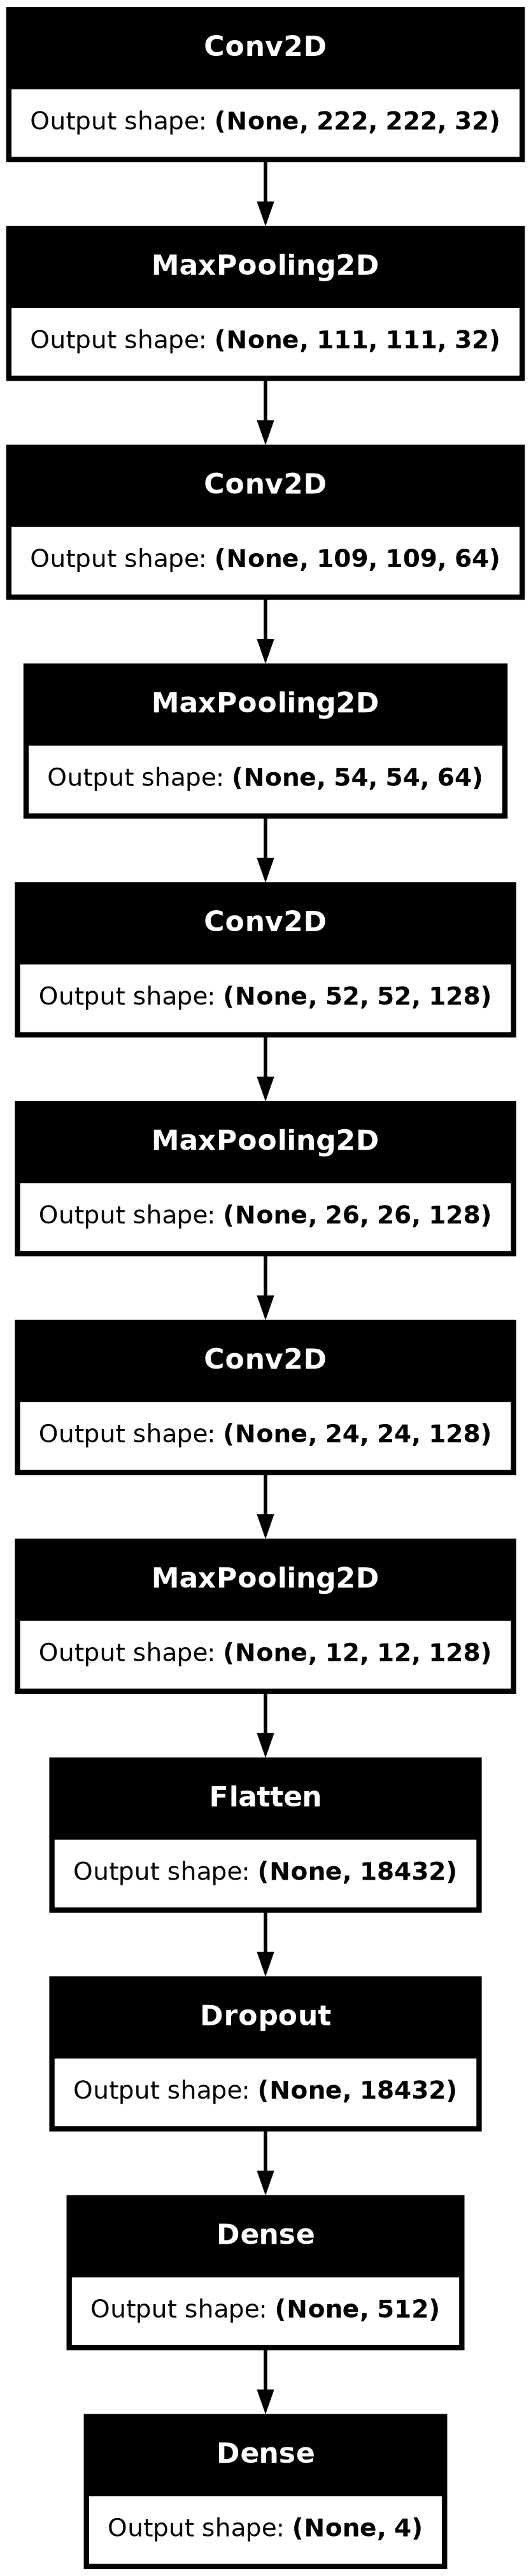

In [27]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8701 - loss: 0.3102
Test Loss: 0.3194035589694977
Test Accuracy: 0.86279296875


In [29]:
# Generate predictions
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)


 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step  

W0000 00:00:1712606401.805959      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step


In [30]:
# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


In [31]:
# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                  precision    recall  f1-score   support

    MildDemented       0.26      0.29      0.27       512
ModerateDemented       0.25      0.25      0.25       512
     NonDemented       0.23      0.20      0.21       512
VeryMildDemented       0.27      0.27      0.27       512

        accuracy                           0.25      2048
       macro avg       0.25      0.25      0.25      2048
    weighted avg       0.25      0.25      0.25      2048



In [32]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)
conf_matrix




<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[149, 122, 120, 121],
       [146, 128, 117, 121],
       [146, 130, 100, 136],
       [140, 133, 101, 138]], dtype=int32)>

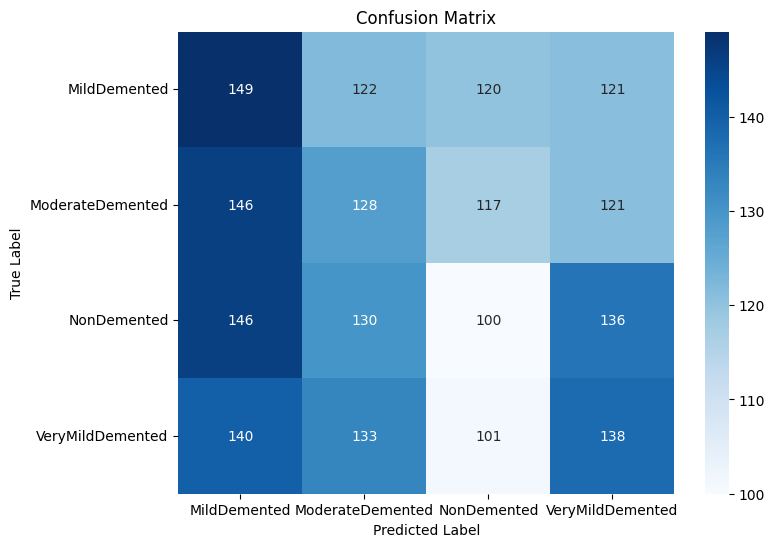

In [33]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
#save model
model.save('alzheimer_detection.h5')